In [80]:
import pandas as pd
import numpy as np
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import linkage
from sklearn.preprocessing import MinMaxScaler
from random import randint
import json

# Przygotowanie danych

In [81]:
def jsonl2df(path):
    with open(path) as fh:
        lines = fh.read().splitlines()

    df_inter = pd.DataFrame(lines)
    df_inter.columns = ['json_element']


    df_inter['json_element'].apply(json.loads)

    return pd.json_normalize(df_inter['json_element'].apply(json.loads))

artists = jsonl2df("datav2/artists.jsonl")
tracks = jsonl2df("datav2/tracks.jsonl")

In [82]:
# Choose data from ranking

# result = ['ranking', 'list', ...]

# tracks[tracks['id'].isin(result)]

In [83]:
# Join tracks with artists
begin_prepared_data = pd.merge(tracks,artists, left_on="id_artist", right_on="id")

# Remove rows with empty values
begin_prepared_data = begin_prepared_data.dropna()
begin_prepared_data = begin_prepared_data.drop(columns=["name_x", "popularity", "id_y", "name_y"])

prepared_data = begin_prepared_data

# Convert dates to number of days from earliest track
prepared_data["release_date"] = pd.to_datetime(prepared_data["release_date"], format = "mixed")
min_date = prepared_data['release_date'].min()
prepared_data['release_date'] = (prepared_data['release_date'] - min_date).dt.days

# Scale the attributes to [0, 1]
without = ['id_x', 'duration_ms', 'id_artist', 'genres']
scaled_columns = list(set(prepared_data.columns).difference(without))
prepared_data[scaled_columns] = MinMaxScaler().fit_transform(prepared_data[scaled_columns])

# One-hot encoding of genres
genres_en = pd.get_dummies(prepared_data['genres'].apply(pd.Series).stack()).groupby(level=0).sum()
prepared_data = pd.concat([prepared_data, genres_en], axis=1)

# One-hot encoding of artists
artists_en = pd.get_dummies(prepared_data['id_artist']).groupby(level=0).sum()
prepared_data = pd.concat([prepared_data, artists_en], axis=1)

prepared_data = prepared_data.drop(columns=['id_artist', 'genres'])

TODO
- Selekcja atrybutów
- Może ograniczyć gatunki i autorów sprawdzając czy występują minimalna liczbę razy, [Infrequent categories sklearn](https://scikit-learn.org/stable/modules/preprocessing.html#infrequent-categories)

In [84]:
TIME_LIMIT = 3600000

# Model podstawowy

- mieszamy kolejność dataframe
- dokładamy do obecnej grupy kolejne utwory dopóki ich suma nie przekroczy godziny i następnie przechodzimy do następnej
- jeżeli ostatnia grupa ma mniej niż godzinę to ją rozdzielamy pomiędzy pozostałe

In [85]:
def base_model(data: pd.DataFrame) -> pd.DataFrame:     # [track_id, group]
    track_times = data[['id_x', 'duration_ms']]

    # mieszanie wierszy
    track_times.sample(frac=1).reset_index(drop=True)
    current_group = 0
    group_sum = 0

    result = []

    for index, row in track_times.iterrows():
        result.append((row['id_x'], current_group))
        group_sum += row['duration_ms']
        if group_sum >= TIME_LIMIT:        # godzina
            group_sum = 0
            current_group += 1

    # ostatnia grupa mniej niż godzina
    if group_sum < TIME_LIMIT:
        for i in range(len(result)):
            if result[-1-i][1] == current_group:
                result[-1-i] = (result[-1-i][0], randint(0,current_group-1))
            else:
                break

    result_df = pd.DataFrame(result, columns=['id', 'group'])
    return result_df

# Model zaawansowany

- korzystamy z algorytmu agglomerative clustering z biblioteki scipy [początkowo chcieliśmy korzystać z biblioteki sklearn ale niestety dopasowywanie grup do danych nie działało poprawnie]
- na początku każdy utwór ma przypisany unikalną grupę oraz otrzymujemy które kolejne klastry mają być łaczone
- łączymy kolejne klastry dopóki wszystkie klastry nie posiadają sumy długości utworów równej co najmniej godzinę
- na końcu jeżeli któraś grupa nie ma więcej niż godziny utworów to jej nie zwracamy

In [86]:
def check_less(data, min_duration=TIME_LIMIT):
    result = []
    for group in data['group'].unique():
        group_data = data[data['group'] == group]
        if group_data['duration_ms'].sum() < min_duration:
            result.append(group)
    return result

In [87]:
def check_all_more_than_hour(data: pd.DataFrame) -> bool:
    return all(data.groupby(by=['group'])['duration_ms'].sum() > TIME_LIMIT)

In [88]:
# Sklearn

# def merge_clusters(data: pd.DataFrame) -> pd.DataFrame:
#     params = data.drop(columns=['duration_ms', 'id_x'])
#     clustering = AgglomerativeClustering(n_clusters=None, distance_threshold=0).fit(params)

#     data['group'] = clustering.labels_

#     n_samples = data.shape[0]

#     # sprawdzać też czy nie przekroczy dystansu
#     for i, (cluster1, cluster2) in enumerate(clustering.children_): # children zawiera listę krotek które klastry się łączą
#         data.loc[data['group'] == cluster1, 'group'] = n_samples + i
#         data.loc[data['group'] == cluster2, 'group'] = n_samples + i
#         if check_all_more_than_hour(data):
#             break
#     return data

In [89]:
def merge_clusters(data):
    params = data.drop(columns=['duration_ms', 'id_x'])
    clustering = linkage(params, method='ward')

    n_samples = data.shape[0]
    data['group'] = range(n_samples)

    for i, (cluster1, cluster2, _, _) in enumerate(clustering):
        data.loc[data['group'] == cluster1, 'group'] = n_samples + i
        data.loc[data['group'] == cluster2, 'group'] = n_samples + i
        if check_all_more_than_hour(data):
            break

    return data

In [90]:
def advanced_model(data: pd.DataFrame) -> pd.DataFrame:     # [track_id, group]
    result = merge_clusters(data)

    less_hour = check_less(result)

    result = data[~data['group'].isin(less_hour)]

    return result[['id_x', 'group']]

TODO
- ustawienie distance_threshold lub innego warunku przerwania

# TESTOWANIE

In [91]:
import numpy as np
from scipy.cluster.hierarchy import dendrogram

def plot_dendrogram(model, **kwargs):
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    dendrogram(linkage_matrix, **kwargs)

In [92]:
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt


def pca_scatter(model, labels, title):
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(model)
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis')
    plt.title(title)
    plt.show()

In [93]:
test = prepared_data[:100]
params = test.drop(columns=['id_x', 'duration_ms'])

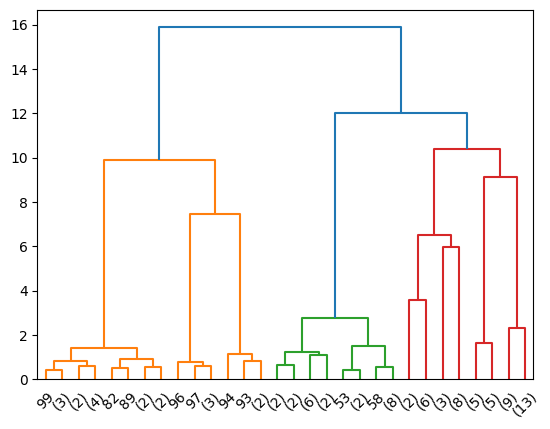

In [114]:
clustering = AgglomerativeClustering(distance_threshold=0, n_clusters=None).fit(params)

plot_dendrogram(clustering, truncate_mode="level", p=4)

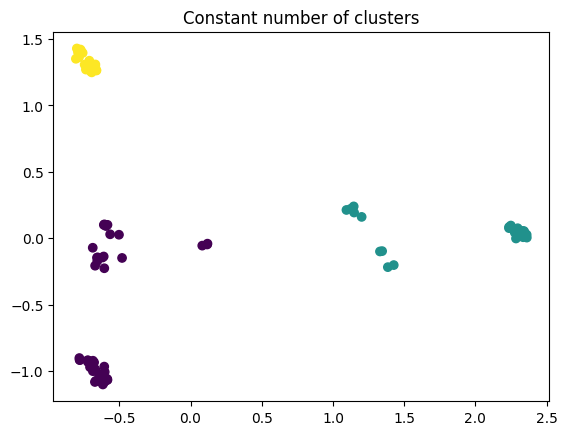

In [95]:
clustering = AgglomerativeClustering(n_clusters=3).fit(params)
labels = clustering.labels_
pca_scatter(params, labels, 'Constant number of clusters')

In [96]:
np.unique(labels, return_counts=True)

(array([0, 1, 2]), array([51, 25, 24]))

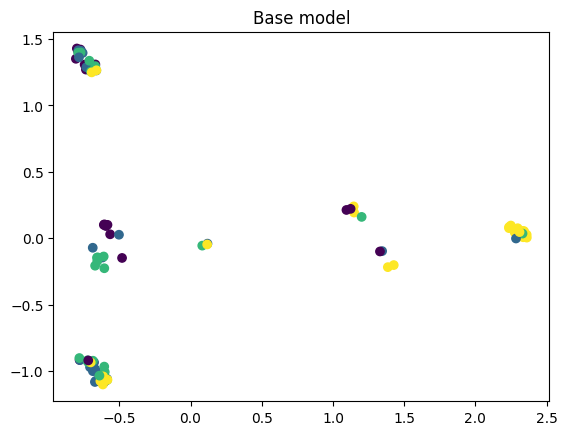

In [97]:
base = base_model(test)

labels = base['group']
pca_scatter(params, labels, 'Base model')

In [98]:
np.unique(labels, return_counts=True)

(array([0, 1, 2, 3]), array([23, 25, 25, 27]))

In [99]:
group_id = labels[0]
result = base[base['group'] == group_id]['id']
first_group_base = begin_prepared_data[begin_prepared_data['id_x'].isin(result)]

In [100]:
first_group_base['duration_ms'].sum() / 1000 / 60 / 60

1.272385

In [101]:
first_group_base.describe()

,duration_ms,explicit,release_date,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
count,23.000000,23.0,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000
mean,199155.913043,0.0,0.264865,0.416105,0.239322,0.525692,0.662988,0.043317,0.802863,0.031700,0.178680,0.379827,0.455650
std,75849.505387,0.0,0.088287,0.166935,0.165880,0.352043,0.091123,0.010937,0.219530,0.107826,0.154547,0.251480,0.091185
min,117560.000000,0.0,0.000000,0.184694,0.054557,0.000000,0.479024,0.028072,0.184738,0.000000,0.078376,0.074067,0.278002
25%,162526.500000,0.0,0.235090,0.279082,0.107015,0.181818,0.603159,0.035699,0.680722,0.000000,0.097970,0.184662,0.397871
50%,186173.000000,0.0,0.292594,0.427551,0.198116,0.636364,0.673089,0.038877,0.886546,0.000005,0.124873,0.314834,0.443818
75%,200520.000000,0.0,0.295027,0.570408,0.320751,0.818182,0.721555,0.047775,0.952309,0.000171,0.175127,0.538345,0.520641
max,423493.000000,0.0,0.376120,0.686735,0.660626,1.000000,0.814703,0.073835,0.993976,0.449900,0.787817,0.970737,0.589748


In [102]:
artists_base = first_group_base['id_artist'].value_counts()
artists_base

id_artist
1Mxqyy3pSjf8kZZL4QVxS0    9
5V0MlUE1Bft0mbLlND7FJz    6
43ZHCT0cAZBISjO8DG9PnE    3
74ASZWbe4lXaubB36ztrGX    2
19eLuQmk9aCobbVDHc6eek    1
3oDbviiivRWhXwIE8hxkVV    1
6hnWRPzGGKiapVX1UCdEAC    1
Name: count, dtype: int64

In [103]:
genres_base = first_group_base['genres'].explode().value_counts()
genres_base

genres
adult standards       20
easy listening         9
lounge                 9
swing                  7
vocal jazz             7
jazz blues             6
rock-and-roll          4
folk rock              3
classic rock           3
rockabilly             3
rock                   3
mellow gold            2
roots rock             2
singer-songwriter      2
brill building pop     2
soul                   2
album rock             2
folk                   2
country rock           2
new orleans jazz       1
jazz trumpet           1
dixieland              1
harlem renaissance     1
baroque pop            1
psychedelic rock       1
sunshine pop           1
classic soul           1
Name: count, dtype: int64

/tmp/ipykernel_12455/4201131422.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['group'] = range(n_samples)


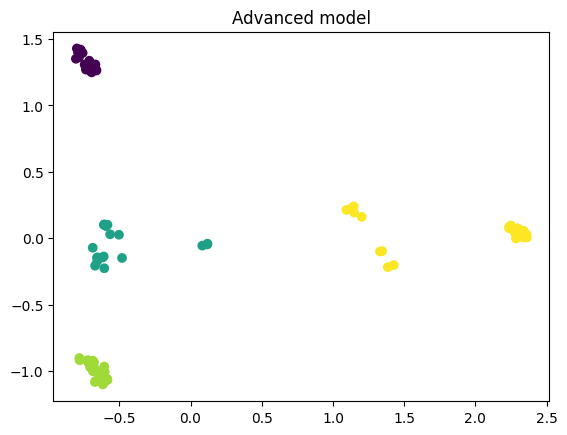

In [104]:
advanced = advanced_model(test)
labels = advanced['group']
params_dropped = test[test['id_x'].isin(advanced['id_x'])].drop(columns=['id_x', 'duration_ms'])
pca_scatter(params, np.array(labels), 'Advanced model')

In [105]:
np.unique(labels, return_counts=True)

(array([188, 192, 194, 195]), array([24, 19, 32, 25]))

Sprawdzenie czy dane w grupie są podobne

In [106]:
group_id = labels[0]
result = advanced[advanced['group'] == group_id]['id_x']
first_group_adv = begin_prepared_data[begin_prepared_data['id_x'].isin(result)]

In [107]:
first_group_adv['duration_ms'].sum() / 1000 / 60 / 60

1.0773308333333333

In [108]:
first_group_adv.describe()

,duration_ms,explicit,release_date,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
count,19.000000,19.0,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000
mean,204125.842105,0.0,0.296806,0.487487,0.303258,0.459330,0.730194,0.051712,0.804322,0.000737,0.213545,0.454352,0.436588
std,61854.192487,0.0,0.079717,0.194065,0.156886,0.302232,0.082604,0.029639,0.140605,0.003050,0.145269,0.225507,0.145538
min,107280.000000,0.0,0.000000,0.187755,0.049351,0.000000,0.516137,0.028178,0.549196,0.000000,0.075939,0.144299,0.278002
25%,177047.000000,0.0,0.292594,0.356122,0.217637,0.227273,0.672478,0.032097,0.710843,0.000000,0.089797,0.262866,0.352326
50%,196133.000000,0.0,0.319447,0.464286,0.285212,0.454545,0.758790,0.036547,0.832329,0.000002,0.156345,0.428860,0.397230
75%,219987.000000,0.0,0.335944,0.663776,0.377313,0.636364,0.794748,0.066790,0.913654,0.000042,0.332995,0.634712,0.467628
max,423493.000000,0.0,0.374904,0.769388,0.585543,0.909091,0.835324,0.130297,0.993976,0.013327,0.522843,0.808274,0.791353


In [109]:
artists_adv = first_group_adv['id_artist'].value_counts()
artists_adv

id_artist
5V0MlUE1Bft0mbLlND7FJz    7
0iOVhN3tnSvgDbcg25JoJb    6
6kACVPfCOnqzgfEF5ryl0x    3
7G1GBhoKtEPnP86X2PvEYO    2
19eLuQmk9aCobbVDHc6eek    1
Name: count, dtype: int64

In [110]:
genres_adv = first_group_adv['genres'].explode().value_counts()
genres_adv

genres
adult standards       16
vocal jazz            16
jazz blues            15
soul                   9
torch song             8
swing                  8
soul blues             6
arkansas country       3
outlaw country         3
soul jazz              2
new orleans jazz       1
jazz trumpet           1
harlem renaissance     1
dixieland              1
Name: count, dtype: int64

Sprawdzanie wariancji, tam gdzie mniejsza tam mniejsza różnica w grupie.

In [111]:
columns = first_group_base.select_dtypes(include=['float']).columns

for index, (b, a) in enumerate(zip(first_group_base.select_dtypes(include=['float']).var(), first_group_adv.select_dtypes(include=['float']).var())):
    if b > a:
        res = 'advanced'
    elif b < a:
        res = 'base'
    else:
        res = 'same'
    print(f'{columns[index]}: {res}')


explicit: same
release_date: advanced
danceability: base
energy: advanced
key: advanced
loudness: advanced
speechiness: base
acousticness: advanced
instrumentalness: advanced
liveness: advanced
valence: advanced
tempo: base


In [112]:
res = 'artists: '
b, a = len(artists_base), len(artists_adv)
if b > a:
    res += 'advanced'
elif b < a:
    res += 'base'
else:
    res += 'same'
print(res)

artists: advanced


In [113]:
res = 'genres: '
b, a = len(genres_base), len(genres_adv)
if b > a:
    res += 'advanced'
elif b < a:
    res += 'base'
else:
    res += 'same'
print(res)

genres: advanced


# Wnioski 
Model zaawansowany tworzy bardziej jednorodne grupy. Ma on jednak na razie trochę wad.
## Model zaawansowany:
- tracimy część danych podczas ostatniego kroku bo nie będą one zwracane
- powinniśmy ustawić dodatkowo distance_threshold aby algorytm nie łączył niepotrzebnie klastrów. Dobrze widoczne jest to na dendogramie, gdy mało liczna grupa, która jeszcze nie spełniła warunku czasowego ma wysoki dystans do kolejnego połączenia. Aktualnie tracimy przez to podobieństwo danych w danej grupie nie zyskując zarazem nowych prawidłowych grup.